In [12]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [14]:
#import the data and the labels
url2='https://raw.githubusercontent.com/mrvoral/Modeling-Late-Payments-for-Credit-Card-Bills/main/hw07_target2_training_data.csv'
df2 = pd.read_csv(url2)


In [15]:
#import labels
label_url2='https://raw.githubusercontent.com/mrvoral/Modeling-Late-Payments-for-Credit-Card-Bills/main/hw07_target2_training_label.csv'
Labels2 = pd.read_csv(label_url2)

In [16]:
test_url2='https://raw.githubusercontent.com/mrvoral/Modeling-Late-Payments-for-Credit-Card-Bills/main/hw07_target2_test_data.csv'
X_test2=pd.read_csv(test_url2)

#  Deal with NaNs

In [17]:
def missing_values_table(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isna().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
            " columns that have missing values.")
    return mis_val_table_ren_columns

In [18]:
missing_values=missing_values_table(df2)

Your selected dataframe has 212 columns.
There are 178 columns that have missing values.


In [19]:
throw_variables=missing_values[missing_values['% of Total Values']>55]
keep_variables=missing_values[missing_values['% of Total Values']<=55]

In [20]:
# iterating the columns
throw_variables
for row in throw_variables.index:
    print(row, end = " ")

VAR185 VAR108 VAR145 VAR188 VAR158 VAR202 VAR207 VAR38 VAR152 VAR209 VAR208 

In [21]:
#drop mostly na features

df2= df2.drop(columns=[row for row in throw_variables.index])

#drop mostly na features
X_test2= X_test2.drop(columns=[row for row in throw_variables.index])



# #fill not-a-numbers with the median
X_test2.fillna(X_test2.median(), inplace=True)



# #fill not-a-numbers with the median
df2.fillna(df2.median(), inplace=True)




Y2=np.array(Labels2)[:,1]



In [24]:

numerical_cols =[ind for ind in keep_variables.index if ind not in ["VAR32","VAR65","VAR195"]]
categorical_cols = ["VAR32","VAR65","VAR195"]
df2= df2.drop(columns=categorical_cols)
X_train=df2

X_test2= X_test2.drop(columns=categorical_cols)
# Inputing numerical values with median
numerical_transformer = SimpleImputer(strategy='median')
# # Inputing missing values with most frequent one for categorical data
# categorical_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='most_frequent')),
#     ('onehot', OneHotEncoder(handle_unknown='ignore'))
# ])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols)
       # ,        ('cat', categorical_transformer, categorical_cols)
    ])


preprocess_pipeline=Pipeline(steps=[
    ('preprocessor', preprocessor)
])
X_train_temp=preprocess_pipeline.fit_transform(X_train)



In [ ]:
df.shape

In [25]:
# train a random forest
#from sklearn.model_selection import GridSearchCV
rfc=RandomForestClassifier()#n_estimators=80,max_depth=7)
# rfc2=RandomForestClassifier()#n_estimators=80,max_depth=5)
# rfc3=RandomForestClassifier()#n_estimators=80,max_depth=7)


## Hyperparameter Search for Target 2




In [26]:
X_train_temp.shape

(9000, 164)

In [28]:

# Number of trees in Random Forest
rf_n_estimators = [int(x) for x in np.linspace(50, 150, 10)]
rf_n_estimators.append(300)
rf_n_estimators.append(400)

# Maximum number of levels in tree
rf_max_depth = [int(x) for x in np.linspace(5, 11, 3)]
# Add the default as a possible value
rf_max_depth.append(None)

# Number of features to consider at every split
rf_max_features = ['auto', 'sqrt', 'log2']

# Criterion to split on
rf_criterion = ['gini', 'entropy']

# Minimum number of samples required to split a node
rf_min_samples_split = [int(x) for x in np.linspace(2, 6, 2)]

# Minimum decrease in impurity required for split to happen
rf_min_impurity_decrease = [0.0, 0.05, 0.5]

# Since the data is huge, no need to turn off bootstrapping
# # Method of selecting samples for training each tree
rf_bootstrap = [True]#, False]

# Create the grid
rf_grid = {'n_estimators': rf_n_estimators,
               'max_depth': rf_max_depth,
               'max_features': rf_max_features,
               'criterion': rf_criterion,
               'min_samples_split': rf_min_samples_split,
               'min_impurity_decrease': rf_min_impurity_decrease,
               'bootstrap': rf_bootstrap}


clf = RandomizedSearchCV(RandomForestClassifier(), rf_grid, n_iter=100, random_state=0)
search = clf.fit(X_train,Y2)
search.best_params_


{'bootstrap': True,
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': 'sqrt',
 'min_impurity_decrease': 0.0,
 'min_samples_split': 6,
 'n_estimators': 83}

In [29]:
best_params=search.best_params_

In [37]:
# Bundle preprocessing and modeling code 
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(**{'bootstrap': True,
 'criterion': 'entropy',
 'max_depth': 7,
 'max_features': 'sqrt',
 'min_impurity_decrease': 0.0,
 'min_samples_split': 6,
 'n_estimators': 83}))#**best_params))
])


In [38]:
#fit and evaluate posterior for training set
pipeline.fit(X_train, Y2)
Y_pred2=pipeline.predict_proba(X_train)[:,1]



In [39]:

#rfc.best_params_
#calculate mean auroc using 10-fold cross validation
from sklearn.model_selection import cross_validate
scores = cross_validate(pipeline, X_train, Y2, cv=5, scoring=('roc_auc'), return_train_score=True)
print("Mean AUROC for target 1 is:")
print(np.mean(scores['test_score']))

# evaluate posteriors on the test set

Y_test2=Y_rf2.predict_proba(X_test2)
#concatanate with ID
Y_o2=np.concatenate((np.array(X_test2["ID"]).reshape((-1,1)),Y_test2[:,1].reshape((-1,1))),1)

write predictions to csv files
pd.DataFrame(Y_o2).to_csv("hw07_target2_test_predictions.csv",header=["ID","TARGET"],index=None)



Mean AUROC for target 1 is:
0.7953467121055908


In [40]:
scores['test_score']

array([0.79783402, 0.78027253, 0.78549247, 0.80180825, 0.81132629])

In [41]:
scores['train_score']

array([0.98505398, 0.98581662, 0.98947876, 0.98682878, 0.98896093])

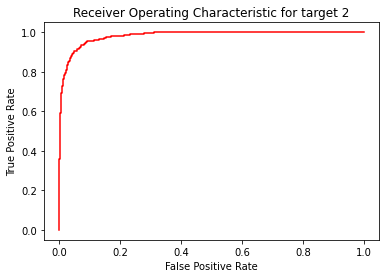

In [42]:
# plot ROC curve
from sklearn import metrics
#fpr, tpr, threshold = metrics.roc_curve(Y, Y_pred)
fpr2, tpr2, threshold = metrics.roc_curve(Y2, Y_pred2)
# fpr3, tpr3, threshold = metrics.roc_curve(Y3, Y_pred3)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic for target 2')
#plt.plot(fpr, tpr, 'b')
plt.plot(fpr2, tpr2, 'r')
# plt.plot(fpr3, tpr3, 'g')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
# plt.legend(('target 1','target 2','target 3'))
plt.show()

In [ ]:
#rfc.best_params_
#calculate mean auroc using 10-fold cross validation
from sklearn.model_selection import cross_validate
scores = cross_validate(pipeline, X_train, Y, cv=10, scoring=('roc_auc'), return_train_score=True)
print("Mean AUROC for target 1 is:")
print(np.mean(scores['test_score']))